# NCF from scratch in Tensorflow
> We will build a Neural Collaborative Filtering model from scratch in Tensorflow and train it on movielens data. Then we will compare it side by side with lightfm model.

- toc: true
- badges: true
- comments: true
- categories: [Movie, NCF, Tensorflow, LightFM]
- author: "<a href='https://www.youtube.com/channel/UCKfMWrjJmeSdCBNsjZu3Jrw'>dataroots</a>"
- image:

> youtube: https://youtu.be/SD3irxdKfxk

## Setup

In [ ]:
!pip install -q lightfm

In [21]:
from scipy import sparse
from typing import List
import datetime
import os

import lightfm
import numpy as np
import pandas as pd
import tensorflow as tf
from lightfm import LightFM
from lightfm.datasets import fetch_movielens

import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

%reload_ext google.colab.data_table
%reload_ext tensorboard

In [6]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

lightfm   : 1.16
pandas    : 1.1.5
scipy     : 1.4.1
numpy     : 1.19.5
tensorflow: 2.5.0
IPython   : 5.5.0



In [7]:
TOP_K = 5
N_EPOCHS = 10

## Load Data

In [8]:
data = fetch_movielens(min_rating=3.0)

print("Interaction matrix:")
print(data["train"].toarray()[:10, :10])

Interaction matrix:
[[5 3 4 3 3 5 4 0 5 3]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 4 4 0]
 [0 0 0 5 0 0 5 5 5 4]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [4 0 0 4 0 0 0 0 4 0]]


In [9]:
for dataset in ["test", "train"]:
    data[dataset] = (data[dataset].toarray() > 0).astype("int8")

# Make the ratings binary
print("Interaction matrix:")
print(data["train"][:10, :10])

print("\nRatings:")
unique_ratings = np.unique(data["train"])
print(unique_ratings)

Interaction matrix:
[[1 1 1 1 1 1 1 0 1 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 1 0]
 [0 0 0 1 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 1 0 0 0 0 1 0]]

Ratings:
[0 1]


## Preprocess

In [11]:
def wide_to_long(wide: np.array, possible_ratings: List[int]) -> np.array:
    """Go from wide table to long.
    :param wide: wide array with user-item interactions
    :param possible_ratings: list of possible ratings that we may have."""

    def _get_ratings(arr: np.array, rating: int) -> np.array:
        """Generate long array for the rating provided
        :param arr: wide array with user-item interactions
        :param rating: the rating that we are interested"""
        idx = np.where(arr == rating)
        return np.vstack(
            (idx[0], idx[1], np.ones(idx[0].size, dtype="int8") * rating)
        ).T

    long_arrays = []
    for r in possible_ratings:
        long_arrays.append(_get_ratings(wide, r))

    return np.vstack(long_arrays)

In [13]:
long_train = wide_to_long(data["train"], unique_ratings)
df_train = pd.DataFrame(long_train, columns=["user_id", "item_id", "interaction"])
df_train.head()

,user_id,item_id,interaction
0,0,7,0
1,0,10,0
2,0,19,0
3,0,20,0
4,0,26,0


In [14]:
print("Only positive interactions:")
df_train[df_train["interaction"] > 0].head()

Only positive interactions:


,user_id,item_id,interaction
1511499,0,0,1
1511500,0,1,1
1511501,0,2,1
1511502,0,3,1
1511503,0,4,1


## NCF Model

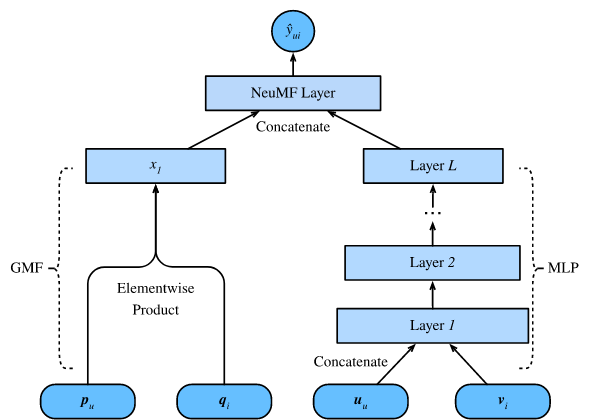

In [16]:
def create_ncf(
    number_of_users: int,
    number_of_items: int,
    latent_dim_mf: int = 4,
    latent_dim_mlp: int = 32,
    reg_mf: int = 0,
    reg_mlp: int = 0.01,
    dense_layers: List[int] = [8, 4],
    reg_layers: List[int] = [0.01, 0.01],
    activation_dense: str = "relu",
) -> keras.Model:

    # input layer
    user = Input(shape=(), dtype="int32", name="user_id")
    item = Input(shape=(), dtype="int32", name="item_id")

    # embedding layers
    mf_user_embedding = Embedding(
        input_dim=number_of_users,
        output_dim=latent_dim_mf,
        name="mf_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mf),
        input_length=1,
    )
    mf_item_embedding = Embedding(
        input_dim=number_of_items,
        output_dim=latent_dim_mf,
        name="mf_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mf),
        input_length=1,
    )

    mlp_user_embedding = Embedding(
        input_dim=number_of_users,
        output_dim=latent_dim_mlp,
        name="mlp_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mlp),
        input_length=1,
    )
    mlp_item_embedding = Embedding(
        input_dim=number_of_items,
        output_dim=latent_dim_mlp,
        name="mlp_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mlp),
        input_length=1,
    )

    # MF vector
    mf_user_latent = Flatten()(mf_user_embedding(user))
    mf_item_latent = Flatten()(mf_item_embedding(item))
    mf_cat_latent = Multiply()([mf_user_latent, mf_item_latent])

    # MLP vector
    mlp_user_latent = Flatten()(mlp_user_embedding(user))
    mlp_item_latent = Flatten()(mlp_item_embedding(item))
    mlp_cat_latent = Concatenate()([mlp_user_latent, mlp_item_latent])

    mlp_vector = mlp_cat_latent

    # build dense layers for model
    for i in range(len(dense_layers)):
        layer = Dense(
            dense_layers[i],
            activity_regularizer=l2(reg_layers[i]),
            activation=activation_dense,
            name="layer%d" % i,
        )
        mlp_vector = layer(mlp_vector)

    predict_layer = Concatenate()([mf_cat_latent, mlp_vector])

    result = Dense(
        1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction"
    )

    output = result(predict_layer)

    model = Model(
        inputs=[user, item],
        outputs=[output],
    )

    return model

In [29]:
n_users, n_items = data["train"].shape
ncf_model = create_ncf(n_users, n_items)

ncf_model.compile(
    optimizer=Adam(),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)
ncf_model._name = "neural_collaborative_filtering"
ncf_model.summary()

Model: "neural_collaborative_filtering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 32)           30176       user_id[0][0]                    
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 32)           53824       item_id[0][0]                    
_____________________________________________________________________

## TF Dataset

In [30]:
def make_tf_dataset(
    df: pd.DataFrame,
    targets: List[str],
    val_split: float = 0.1,
    batch_size: int = 512,
    seed=42,
):
    """Make TensorFlow dataset from Pandas DataFrame.
    :param df: input DataFrame - only contains features and target(s)
    :param targets: list of columns names corresponding to targets
    :param val_split: fraction of the data that should be used for validation
    :param batch_size: batch size for training
    :param seed: random seed for shuffling data - `None` won't shuffle the data"""

    n_val = round(df.shape[0] * val_split)
    if seed:
        # shuffle all the rows
        x = df.sample(frac=1, random_state=seed).to_dict("series")
    else:
        x = df.to_dict("series")
    y = dict()
    for t in targets:
        y[t] = x.pop(t)
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)
    return ds_train, ds_val

In [31]:
# create train and validation datasets
ds_train, ds_val = make_tf_dataset(df_train, ["interaction"])

## Model Training

In [32]:
%%time
# define logs and callbacks
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2
)

train_hist = ncf_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=N_EPOCHS,
    callbacks=[tensorboard_callback, early_stopping_callback],
    verbose=1,
)

Epoch 1/10
2789/2789 [==============================] - 21s 7ms/step - loss: 0.2304 - tp: 1031.0000 - fp: 828.0000 - tn: 1359586.0000 - fn: 66068.0000 - accuracy: 0.9531 - precision: 0.5546 - recall: 0.0154 - auc: 0.7983 - val_loss: 0.1338 - val_tp: 882.0000 - val_fp: 356.0000 - val_tn: 150729.0000 - val_fn: 6646.0000 - val_accuracy: 0.9559 - val_precision: 0.7124 - val_recall: 0.1172 - val_auc: 0.9138
Epoch 2/10
2789/2789 [==============================] - 17s 6ms/step - loss: 0.1204 - tp: 13114.0000 - fp: 6911.0000 - tn: 1353503.0000 - fn: 53985.0000 - accuracy: 0.9573 - precision: 0.6549 - recall: 0.1954 - auc: 0.9243 - val_loss: 0.1164 - val_tp: 1709.0000 - val_fp: 878.0000 - val_tn: 150207.0000 - val_fn: 5819.0000 - val_accuracy: 0.9578 - val_precision: 0.6606 - val_recall: 0.2270 - val_auc: 0.9263
Epoch 3/10
2789/2789 [==============================] - 17s 6ms/step - loss: 0.1122 - tp: 16039.0000 - fp: 8355.0000 - tn: 1352059.0000 - fn: 51060.0000 - accuracy: 0.9584 - precision: 

In [ ]:
%tensorboard --logdir logs

## Inference

In [33]:
long_test = wide_to_long(data["train"], unique_ratings)
df_test = pd.DataFrame(long_test, columns=["user_id", "item_id", "interaction"])
ds_test, _ = make_tf_dataset(df_test, ["interaction"], val_split=0, seed=None)

In [34]:
ncf_predictions = ncf_model.predict(ds_test)
df_test["ncf_predictions"] = ncf_predictions

In [35]:
df_test.head()

,user_id,item_id,interaction,ncf_predictions
0,0,7,0,0.592035
1,0,10,0,0.558495
2,0,19,0,0.125240
3,0,20,0,0.136281
4,0,26,0,0.125943


> Tip: sanity checks. stop execution if low standard deviation (all recommendations are the same)

In [45]:
std = df_test.describe().loc["std", "ncf_predictions"]
if std < 0.01:
    raise ValueError("Model predictions have standard deviation of less than 1e-2.")

In [46]:
data["ncf_predictions"] = df_test.pivot(
    index="user_id", columns="item_id", values="ncf_predictions"
).values
print("Neural collaborative filtering predictions")
print(data["ncf_predictions"][:10, :4])

Neural collaborative filtering predictions
[[7.5572348e-01 3.5788852e-01 2.1718740e-01 7.2733581e-01]
 [1.5290251e-01 1.6686320e-03 3.1808287e-02 2.9422939e-03]
 [2.7413875e-02 2.9927492e-04 1.8543899e-03 1.5550852e-04]
 [7.2024286e-02 9.6502900e-04 1.9236505e-03 8.1184506e-04]
 [6.6356444e-01 2.3927736e-01 1.2042263e-01 3.8960028e-01]
 [4.0644848e-01 3.1249046e-02 1.5729398e-02 4.7397730e-01]
 [7.1385705e-01 6.5075237e-01 2.0070928e-01 8.8203180e-01]
 [4.3854299e-01 5.6260496e-02 3.0884445e-03 6.0800165e-02]
 [1.6601676e-01 6.6775084e-04 3.9201975e-04 3.1027198e-03]
 [4.4480303e-01 8.1428647e-02 3.0222714e-02 4.7680125e-01]]


In [50]:
precision_ncf = tf.keras.metrics.Precision(top_k=TOP_K)
recall_ncf = tf.keras.metrics.Recall(top_k=TOP_K)

precision_ncf.update_state(data["test"], data["ncf_predictions"])
recall_ncf.update_state(data["test"], data["ncf_predictions"])
print(
    f"At K = {TOP_K}, we have a precision of {precision_ncf.result().numpy():.5f}, and a recall of {recall_ncf.result().numpy():.5f}",
)

At K = 5, we have a precision of 0.10838, and a recall of 0.06474


## Comparison with LightFM (WARP loss) model

In [49]:
# LightFM model
def norm(x: float) -> float:
    """Normalize vector"""
    return (x - np.min(x)) / np.ptp(x)


lightfm_model = LightFM(loss="warp")
lightfm_model.fit(sparse.coo_matrix(data["train"]), epochs=N_EPOCHS)

lightfm_predictions = lightfm_model.predict(
    df_test["user_id"].values, df_test["item_id"].values
)
df_test["lightfm_predictions"] = lightfm_predictions
wide_predictions = df_test.pivot(
    index="user_id", columns="item_id", values="lightfm_predictions"
).values
data["lightfm_predictions"] = norm(wide_predictions)

# compute the metrics
precision_lightfm = tf.keras.metrics.Precision(top_k=TOP_K)
recall_lightfm = tf.keras.metrics.Recall(top_k=TOP_K)
precision_lightfm.update_state(data["test"], data["lightfm_predictions"])
recall_lightfm.update_state(data["test"], data["lightfm_predictions"])
print(
    f"At K = {TOP_K}, we have a precision of {precision_lightfm.result().numpy():.5f}, and a recall of {recall_lightfm.result().numpy():.5f}",
)

At K = 5, we have a precision of 0.10944, and a recall of 0.06537
